In [1]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

2023-03-14 11:11:19.537795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-14 11:11:19.537869: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-14 11:11:19.537877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tensorflow.keras import layers
import pickle
import time
from numpy import load
from matplotlib import pyplot
import pickle
import argparse

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel as sum_channels_parallel
from sklearn.metrics import mean_absolute_error
from datetime import datetime

2.11.0


### Load and process data

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import sklearn
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [4]:
data = pd.read_pickle('../data/data_proton_photonsum_30_2312.pkl')
print('Loaded: ',  data.shape, "max:", data.max())

data_cond = pd.read_pickle('../data/data_cond_photonsum_30_2312_0_3360.pkl')
print('Loaded cond: ',  data_cond.shape, "max:",data_cond.values.max(), "min:",data_cond.values.min())

Loaded:  (59684, 56, 30) max: 765.0
Loaded cond:  (59684, 12) max: 7000.0 min: -7000.0


In [5]:
photon_sum_proton_min, photon_sum_proton_max = data_cond.proton_photon_sum.min(), data_cond.proton_photon_sum.max()
photon_sum_neutron_min, photon_sum_neutron_max = data_cond.neutron_photon_sum.min(), data_cond.neutron_photon_sum.max()

In [6]:
data_cond.drop(columns=['proton_photon_sum', 'neutron_photon_sum'], inplace=True)
data_cond.columns, len(data_cond.columns)

(Index(['Pdg', 'Energy', 'Vx', 'Vy', 'Vz', 'Px', 'Py', 'Pz', 'mass', 'charge'], dtype='object'),
 10)

In [7]:
DATE_STR = datetime.now().strftime("%d_%m_%Y_%H_%M")

NAME = "gan"

EXPERIMENT_DIR_NAME = f"{NAME}_{DATE_STR}"

print("Experiment DIR: ", EXPERIMENT_DIR_NAME)

Experiment DIR:  gan_14_03_2023_11_11


In [8]:
def create_dir(path):
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

In [9]:
def save_scales(model_name, scaler_means, scaler_scales):
    out_fnm = f"{model_name}_scales.txt"
    res = "#means"
    for mean_ in scaler_means:
        res += "\n" + str(mean_)
    res += "\n\n#scales"
    for scale_ in scaler_scales:
        res += "\n" + str(scale_)

    filepath = f"../models/{EXPERIMENT_DIR_NAME}/"
    create_dir(filepath)
    with open(filepath+out_fnm, mode="w") as f:
        f.write(res)

In [10]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

#save scales
save_scales("Proton", scaler.mean_, scaler.scale_)

data max 6.641182 min 0.0
cond max 13.531697 min -20.69023


In [11]:
x_train, x_test, y_train, y_test, = train_test_split(data, data_cond, test_size=0.2, shuffle=False, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(47747, 56, 30) (11937, 56, 30) (47747, 10) (11937, 10)


In [12]:
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
fake_cond =  tf.data.Dataset.from_tensor_slices(y_train).shuffle(12800).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset,dataset_cond, fake_cond)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_fake_cond =  tf.data.Dataset.from_tensor_slices(y_test).shuffle(12800).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset,val_dataset_cond,val_fake_cond)).shuffle(12800)

### Define Model

In [13]:
from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from tensorflow import keras

In [14]:
latent_dim = 10
cond_dim = 10
poz_dim = 6

############################ generator ############################

x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])

layer_1 = Dense(128*2)(inputs)
layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

layer_2 = Dense(128*8*4)(layer_1_a)
layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

reshaped = Reshape((8,4,128))(layer_2_a)
reshaped_s = UpSampling2D(size=(2,2))(reshaped)

conv1 = Conv2D(128, kernel_size=3, padding='same')(reshaped_s)
conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
conv1_a_s = UpSampling2D(size=(4,4))(conv1_a)

conv2 = Conv2D(64, kernel_size=(7, 1))(conv1_a_s)
conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)

outputs = Conv2D(1, kernel_size=3, activation='relu')(conv2_a)

generator = Model([x, cond], outputs, name='generator')
generator.summary()

############################ discriminator ############################

input_img = Input(shape=[56,30,1],name='input_img')
conv1 = Conv2D(32, kernel_size=3)(input_img)
conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_a)
conv2 = Conv2D(16, kernel_size=3)(pool1)
conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
pool2 = MaxPooling2D(pool_size=(2, 1))(conv2_a)
flat = Flatten()(pool2)
cond = Input(shape=(cond_dim,))
inputs2 = Concatenate(axis=1)([flat, cond])
layer_1 = Dense(128)(inputs2)
layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)
layer_2 = Dense(64)(layer_1_a)
layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)
outputs = Dense(1, activation='sigmoid')(layer_2_a)

discriminator = Model([input_img, cond], outputs, name='discriminator')
discriminator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 20)           0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 256)          5376        ['concatenate[0][0]']    

In [15]:
# latent_dim = 10
# cond_dim = 10
# poz_dim = 6

# ############################ generator ############################

# x = Input(shape=(latent_dim,))
# cond = Input(shape=(cond_dim,))
# inputs = Concatenate(axis=1)([x, cond])

# layer_1 = Dense(128*2)(inputs)
# layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
# layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

# layer_2 = Dense(128*28*15)(layer_1_a)
# layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
# layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

# reshaped = Reshape((28, 15, 128))(layer_2_a)
# # reshaped_s = UpSampling2D()(reshaped)

# conv1 = Conv2D(128, kernel_size=1)(reshaped)
# conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
# conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
# conv1_a_s = UpSampling2D()(conv1_a)

# conv2 = Conv2D(64, kernel_size=1)(conv1_a_s)
# conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
# conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)

# outputs = Conv2D(1, kernel_size=1,activation='relu')(conv2_a)

# generator = Model([x, cond], outputs, name='generator')
# generator.summary()

# ############################ discriminator ############################

# input_img = Input(shape=[56,30,1],name='input_img')
# conv1 = Conv2D(32, kernel_size=3)(input_img)
# conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
# conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_a)
# conv2 = Conv2D(16, kernel_size=3)(pool1)
# conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
# conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_a)
# flat = Flatten()(pool2)
# cond = Input(shape=(cond_dim,))

# inputs2 = Concatenate(axis=1)([flat, cond])
# layer_1 = Dense(128)(inputs2)
# layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
# layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)
# layer_2 = Dense(64)(layer_1_a)
# layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
# layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)
# outputs = Dense(1, activation='sigmoid')(layer_2_a)

# discriminator = Model([input_img, cond], outputs, name='discriminator')
# discriminator.summary()

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    d_acc_r.update_state(tf.ones_like(real_output), real_output)
    d_acc_f.update_state(tf.zeros_like(fake_output), fake_output)
    return total_loss

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

In [19]:
def generator_loss(step, fake_output):
    g_acc.update_state(tf.ones_like(fake_output), fake_output)
    return cross_entropy(tf.ones_like(fake_output), fake_output)# - div

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
EPOCHS = 100
noise_dim = 10
num_examples_to_generate = 16

# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[20:20+num_examples_to_generate]

In [22]:
from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel
from sklearn.metrics import mean_absolute_error

org=np.exp(x_test)-1
ch_org = np.array(org).reshape(-1,56,30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values 
del org


def calculate_ws_ch(n_calc):
    ws= [0,0,0,0,0]
    for j in range(n_calc):
        z = np.random.normal(0,1,(x_test.shape[0],10))
        z_c = y_test
        results = generator.predict([z,z_c])
        results = np.exp(results)-1
        try:
            ch_gen = np.array(results).reshape(-1,56,30)
            ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
            for i in range(5):
                ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
            ws =np.array(ws)
        except ValueError as e:
            print(e)
    ws = ws/n_calc
    print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
    for n,score in enumerate(ws):
        print("ch"+str(n+1),f'{score:.2f}',end=" ")


In [23]:
@tf.function
def train_step(batch,step):
    images, cond, noise_cond = batch
    step=step
    BATCH_SIZE = tf.shape(images)[0]
    noise = tf.random.normal([BATCH_SIZE, noise_dim])


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise,noise_cond], training=True)

        real_output = discriminator([images,cond], training=True)
        fake_output = discriminator([generated_images, noise_cond], training=True)

        gen_loss = generator_loss(step, fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [24]:
filepath_mod = f"../models/{EXPERIMENT_DIR_NAME}/"
create_dir(filepath_mod)

history = []
def train(dataset, epochs):
    tf_step =tf.Variable(0, dtype=float)
    step=0
    
    # genrate first image
    generate_and_save_images(generator,
                             epochs,
                             [seed, seed_cond])

    for epoch in range(epochs):
        start = time.time()

        for batch in dataset:
            gen_loss, disc_loss =train_step(batch,tf_step)
            history.append([gen_loss,disc_loss,
                100*d_acc_r.result().numpy(),
                100*d_acc_f.result().numpy(),
                100*g_acc.result().numpy(),
                ])
            tf_step.assign_add(1)
            step = step+1

            if step % 100 == 0:
                print("%d [D real acc: %.2f%%] [D fake acc: %.2f%%] [G acc: %.2f%%] "% (
                    step,
                    100*d_acc_r.result().numpy(),
                    100*d_acc_f.result().numpy(),
                    100*g_acc.result().numpy()))

        generate_and_save_images(generator,
                                 epoch,
                                 [seed, seed_cond])

        # Save the model every epoch
        generator.compile()
        discriminator.compile()
        generator.save((os.path.join(filepath_mod, "gen_"+NAME + "_"+ str(epoch) +".h5")))
        discriminator.save((os.path.join(filepath_mod, "disc_"+NAME + "_"+ str(epoch) +".h5")))
        np.savez(os.path.join(filepath_mod, "history_"+NAME+".npz"),np.array(history))

        calculate_ws_ch(min(epoch//5+1,5))

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # generate last image
    generate_and_save_images(generator,
                             epochs + 1,
                             [seed, seed_cond]
                            )

    return history

In [25]:
filepath_img = f"../images/{EXPERIMENT_DIR_NAME}/"
create_dir(filepath_img)

def generate_and_save_images(model, epoch, test_input):
    
    SUPTITLE_TXT = f"\nModel: GAN proton data" \
               f"\nPhotonsum interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nEPOCH: {epoch}"
    
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)  # returns 16 responses

    fig, axs = plt.subplots(2, 7, figsize=(15, 5))
    fig.suptitle(SUPTITLE_TXT, x=0.1, horizontalalignment='left')

    for i in range(0, 14):
        if i < 7:
            x = x_test[20 + i].reshape(56, 30)
        else:
            x = predictions[i - 7].numpy().reshape(56, 30)
        #x[x<=0]=x.max()*-0.1
        im = axs[i // 7, i % 7].imshow(x, cmap='gnuplot')
        axs[i // 7, i % 7].axis('off')
        fig.colorbar(im, ax=axs[i // 7, i % 7])

    fig.tight_layout(rect=[0, 0, 1, 0.975])
    plt.savefig(os.path.join(filepath_img, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

### Train model

Images are saved in:  ../images/gan_14_03_2023_11_11/
Models are saved in:  ../models/gan_14_03_2023_11_11/


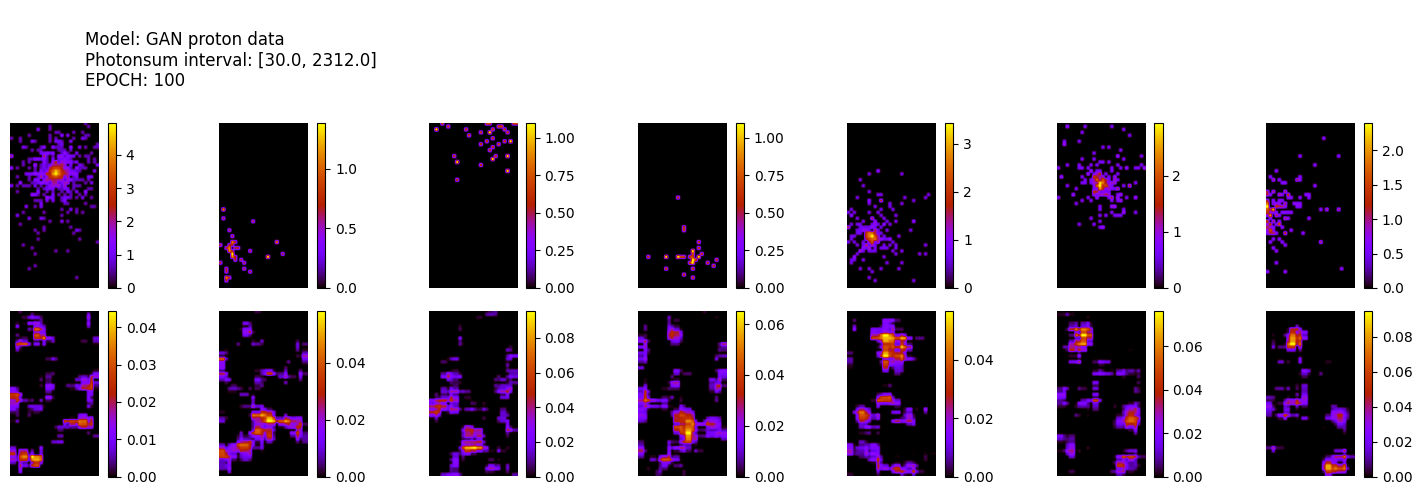

100 [D real acc: 71.54%] [D fake acc: 33.63%] [G acc: 66.37%] 
200 [D real acc: 71.53%] [D fake acc: 37.99%] [G acc: 62.01%] 
300 [D real acc: 70.03%] [D fake acc: 39.97%] [G acc: 60.03%] 


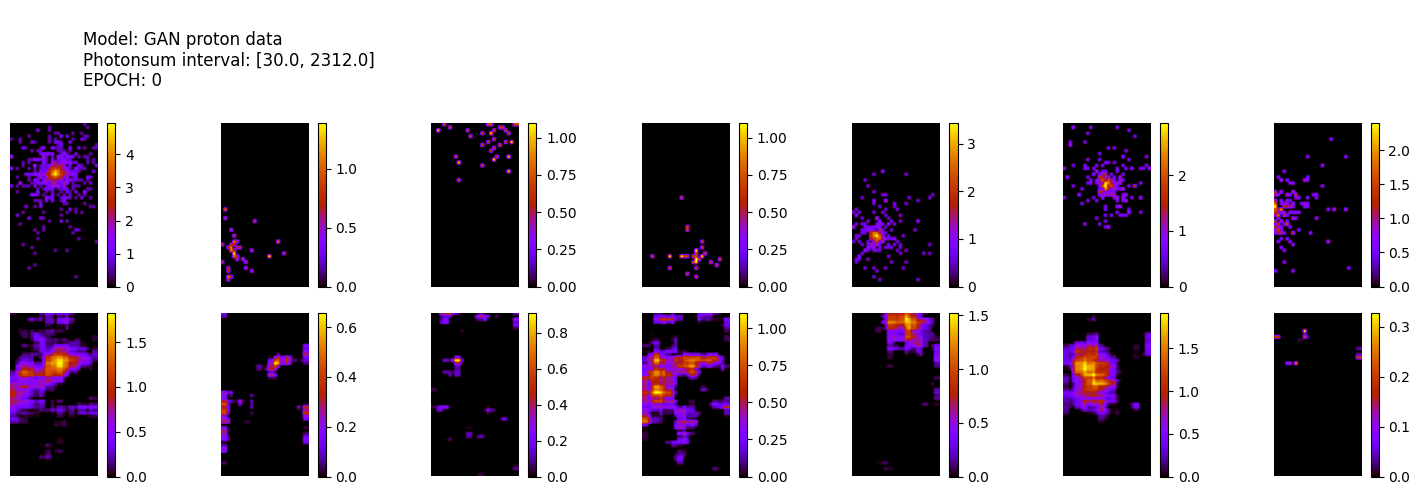

374/374 [==============================] - 2s 4ms/step
ws mean 54.63 ch1 0.10 ch2 43.93 ch3 0.21 ch4 92.81 ch5 136.11 Time for epoch 1 is 44.74935007095337 sec
400 [D real acc: 68.19%] [D fake acc: 43.55%] [G acc: 56.45%] 
500 [D real acc: 68.19%] [D fake acc: 46.63%] [G acc: 53.37%] 
600 [D real acc: 68.23%] [D fake acc: 48.74%] [G acc: 51.26%] 
700 [D real acc: 68.48%] [D fake acc: 50.40%] [G acc: 49.60%] 


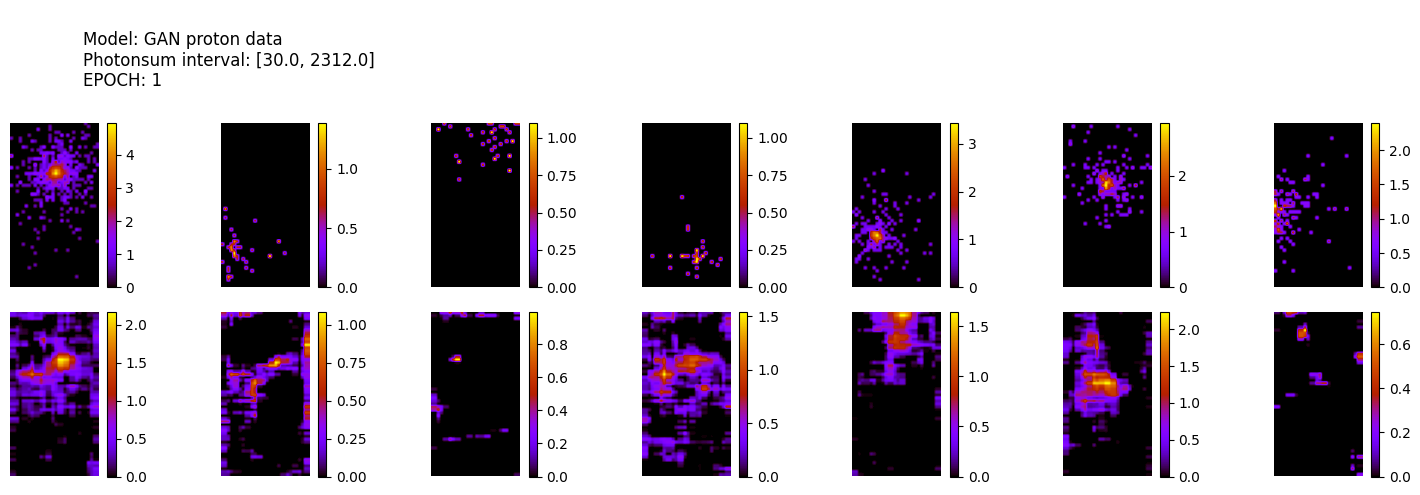

374/374 [==============================] - 2s 4ms/step
ws mean 47.92 ch1 0.09 ch2 34.81 ch3 0.20 ch4 85.23 ch5 119.26 Time for epoch 2 is 33.66867399215698 sec
800 [D real acc: 68.55%] [D fake acc: 52.14%] [G acc: 47.86%] 
900 [D real acc: 68.58%] [D fake acc: 53.56%] [G acc: 46.44%] 
1000 [D real acc: 68.67%] [D fake acc: 54.86%] [G acc: 45.14%] 
1100 [D real acc: 68.84%] [D fake acc: 56.04%] [G acc: 43.96%] 


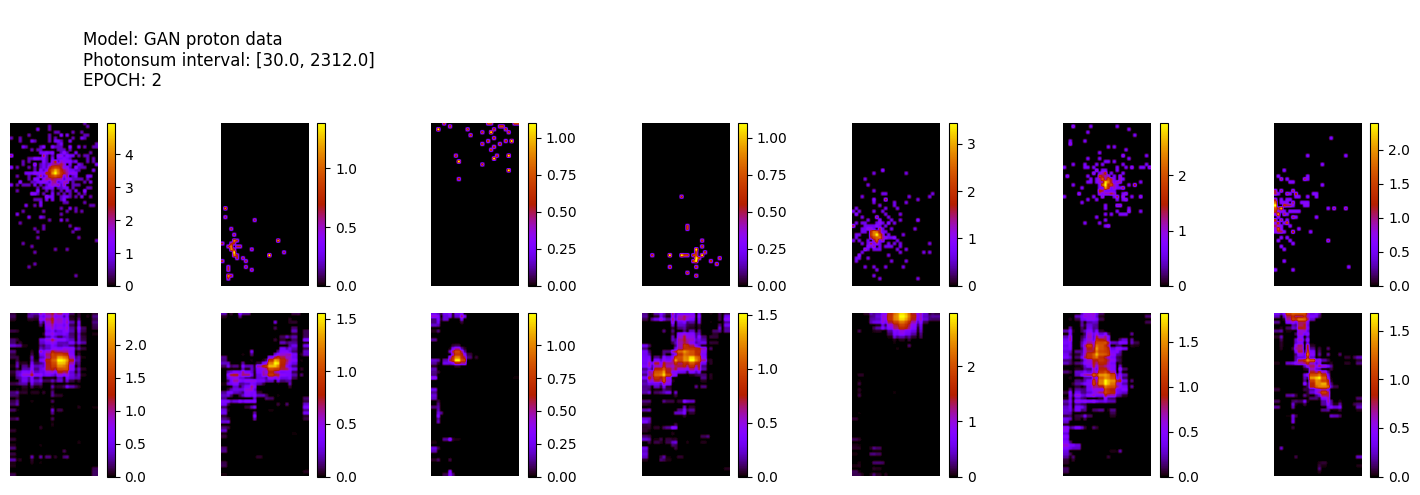

374/374 [==============================] - 2s 4ms/step
ws mean 33.11 ch1 0.13 ch2 31.83 ch3 0.16 ch4 50.53 ch5 82.89 Time for epoch 3 is 33.93727946281433 sec
1200 [D real acc: 69.05%] [D fake acc: 57.20%] [G acc: 42.80%] 
1300 [D real acc: 69.23%] [D fake acc: 58.11%] [G acc: 41.89%] 
1400 [D real acc: 69.50%] [D fake acc: 58.86%] [G acc: 41.14%] 


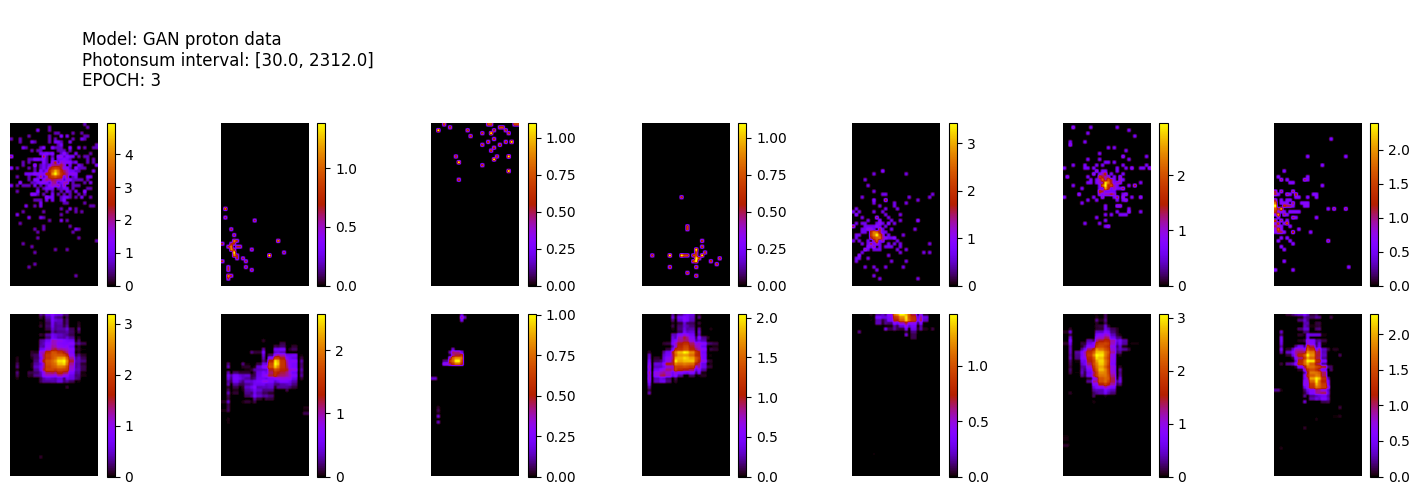

374/374 [==============================] - 1s 4ms/step
ws mean 28.02 ch1 0.06 ch2 25.02 ch3 0.13 ch4 47.16 ch5 67.71 Time for epoch 4 is 33.72515296936035 sec
1500 [D real acc: 69.76%] [D fake acc: 59.48%] [G acc: 40.52%] 
1600 [D real acc: 69.91%] [D fake acc: 60.11%] [G acc: 39.89%] 
1700 [D real acc: 70.10%] [D fake acc: 60.66%] [G acc: 39.34%] 
1800 [D real acc: 70.33%] [D fake acc: 61.17%] [G acc: 38.83%] 


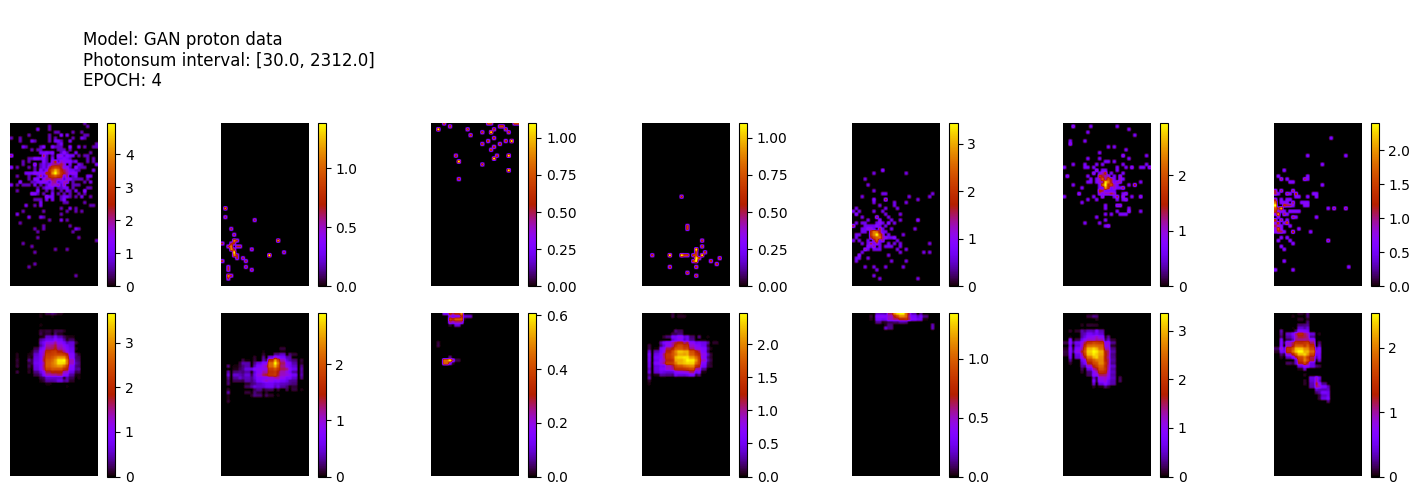

374/374 [==============================] - 2s 4ms/step
ws mean 33.33 ch1 0.13 ch2 25.52 ch3 0.21 ch4 63.33 ch5 77.45 Time for epoch 5 is 34.11260795593262 sec
1900 [D real acc: 70.53%] [D fake acc: 61.68%] [G acc: 38.32%] 
2000 [D real acc: 70.78%] [D fake acc: 62.22%] [G acc: 37.78%] 
2100 [D real acc: 71.04%] [D fake acc: 62.80%] [G acc: 37.20%] 
2200 [D real acc: 71.28%] [D fake acc: 63.38%] [G acc: 36.62%] 


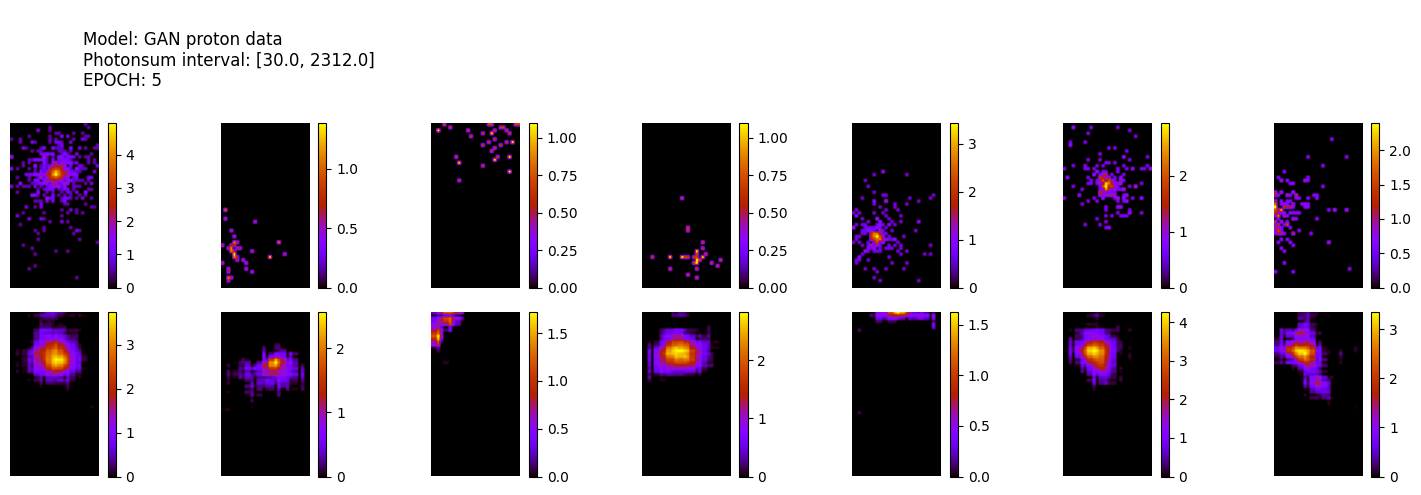

374/374 [==============================] - 1s 4ms/step
ws mean 40.40 ch1 0.12 ch2 30.99 ch3 0.15 ch4 72.74 ch5 98.00 Time for epoch 6 is 36.93475151062012 sec
2300 [D real acc: 71.61%] [D fake acc: 63.93%] [G acc: 36.07%] 
2400 [D real acc: 71.90%] [D fake acc: 64.47%] [G acc: 35.53%] 
2500 [D real acc: 72.24%] [D fake acc: 65.07%] [G acc: 34.93%] 
2600 [D real acc: 72.54%] [D fake acc: 65.63%] [G acc: 34.37%] 


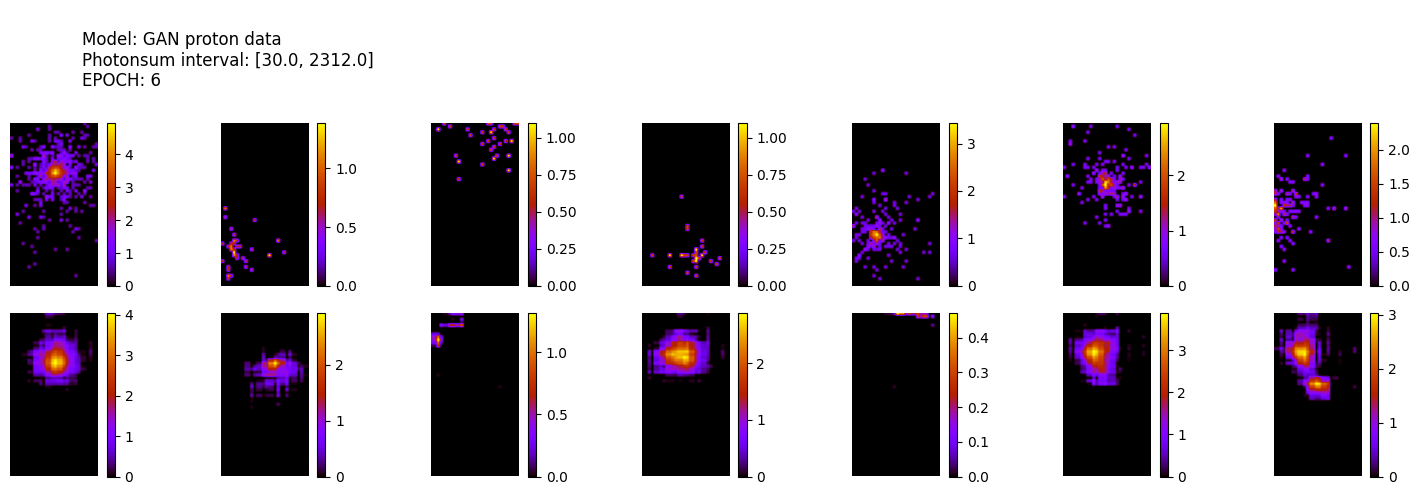

374/374 [==============================] - 1s 4ms/step
ws mean 35.41 ch1 0.12 ch2 40.65 ch3 0.16 ch4 58.47 ch5 77.62 Time for epoch 7 is 37.29577684402466 sec
2700 [D real acc: 72.90%] [D fake acc: 66.18%] [G acc: 33.82%] 
2800 [D real acc: 73.24%] [D fake acc: 66.71%] [G acc: 33.29%] 
2900 [D real acc: 73.61%] [D fake acc: 67.27%] [G acc: 32.73%] 


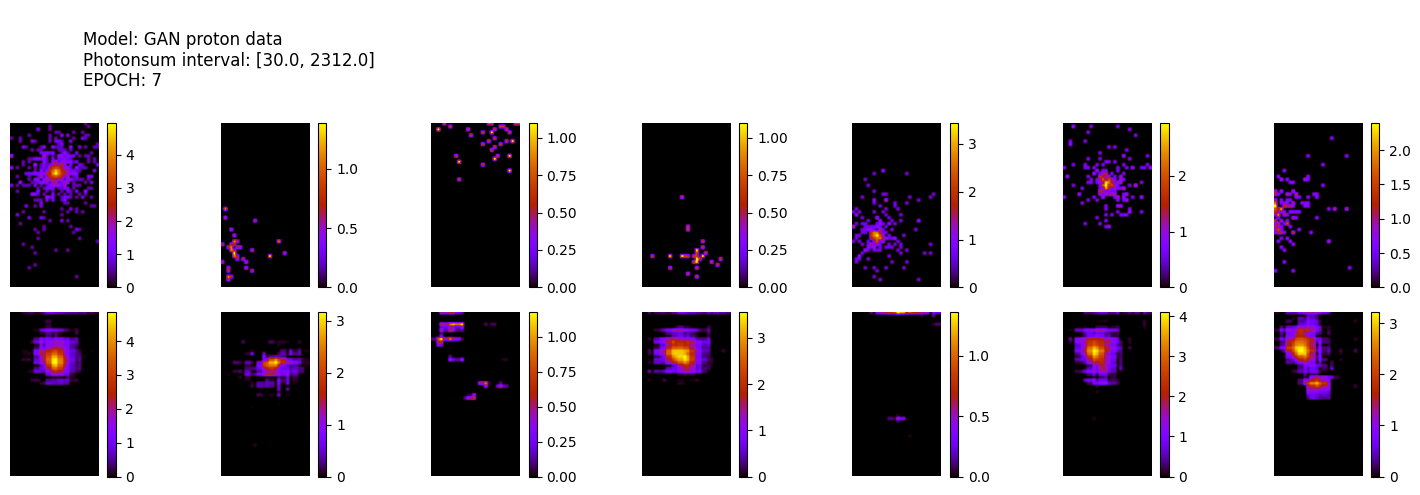

374/374 [==============================] - 1s 4ms/step
ws mean 49.21 ch1 0.08 ch2 34.02 ch3 0.44 ch4 95.33 ch5 116.17 Time for epoch 8 is 37.03367352485657 sec
3000 [D real acc: 74.00%] [D fake acc: 67.81%] [G acc: 32.19%] 
3100 [D real acc: 74.37%] [D fake acc: 68.35%] [G acc: 31.65%] 
3200 [D real acc: 74.74%] [D fake acc: 68.91%] [G acc: 31.09%] 
3300 [D real acc: 75.11%] [D fake acc: 69.44%] [G acc: 30.56%] 


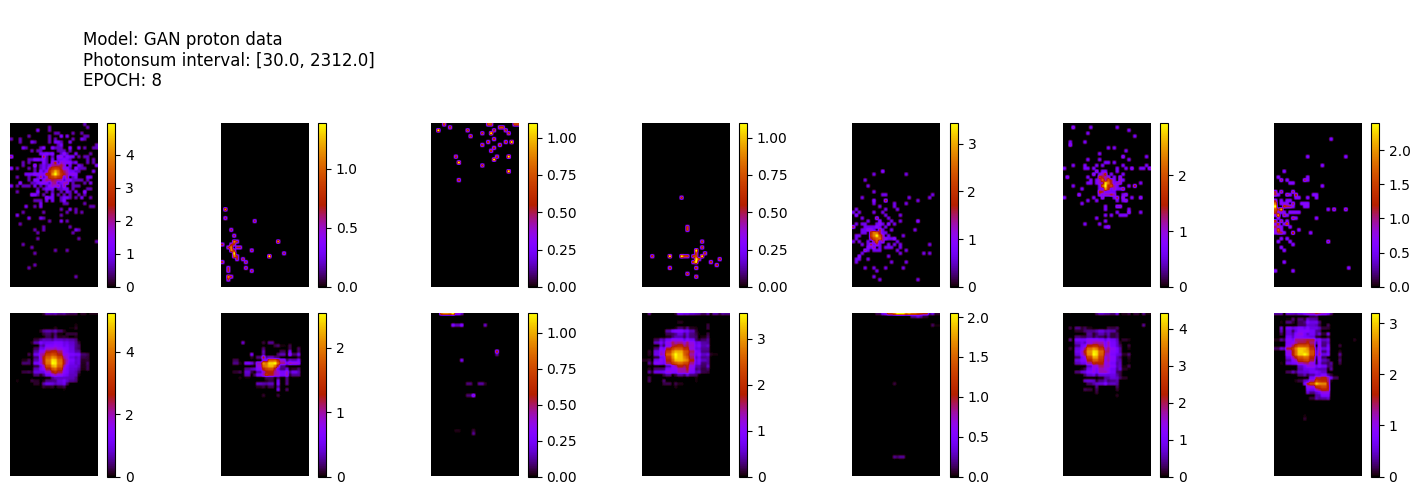

374/374 [==============================] - 1s 4ms/step
ws mean 46.28 ch1 0.17 ch2 42.46 ch3 0.29 ch4 78.64 ch5 109.86 Time for epoch 9 is 37.28906536102295 sec
3400 [D real acc: 75.51%] [D fake acc: 69.97%] [G acc: 30.03%] 
3500 [D real acc: 75.90%] [D fake acc: 70.47%] [G acc: 29.53%] 
3600 [D real acc: 76.28%] [D fake acc: 70.93%] [G acc: 29.07%] 
3700 [D real acc: 76.67%] [D fake acc: 71.45%] [G acc: 28.55%] 


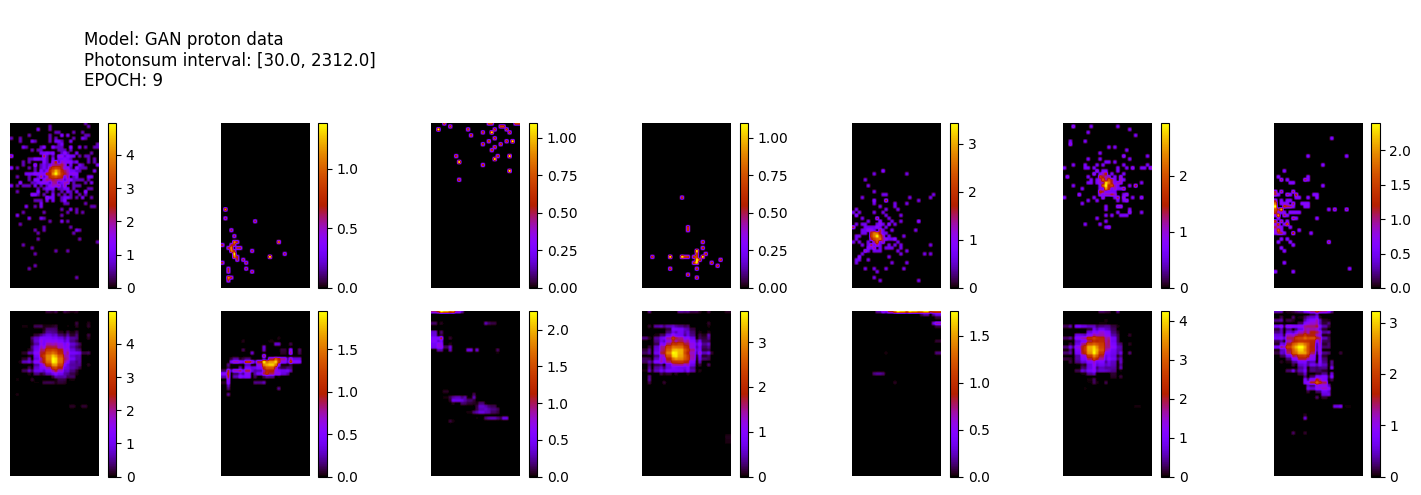

374/374 [==============================] - 1s 4ms/step
ws mean 64.30 ch1 0.09 ch2 44.11 ch3 0.91 ch4 128.92 ch5 147.47 Time for epoch 10 is 37.28606367111206 sec
3800 [D real acc: 77.06%] [D fake acc: 71.93%] [G acc: 28.07%] 
3900 [D real acc: 77.44%] [D fake acc: 72.42%] [G acc: 27.58%] 
4000 [D real acc: 77.82%] [D fake acc: 72.93%] [G acc: 27.07%] 
4100 [D real acc: 78.19%] [D fake acc: 73.36%] [G acc: 26.64%] 


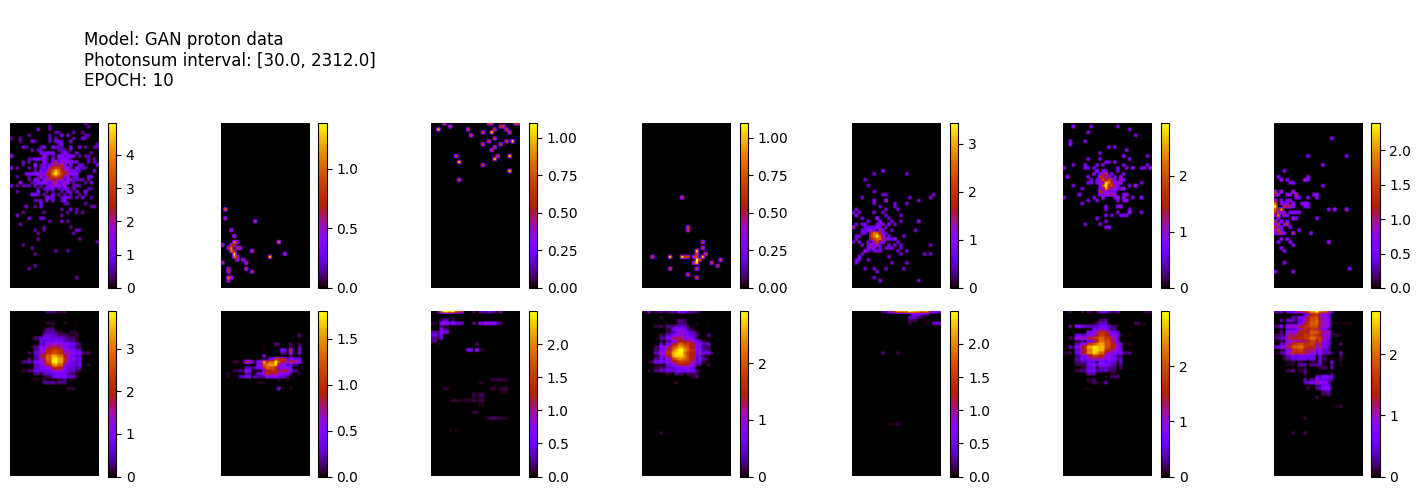

374/374 [==============================] - 1s 4ms/step
ws mean 61.73 ch1 0.10 ch2 38.64 ch3 0.52 ch4 125.35 ch5 144.04 Time for epoch 11 is 40.141292333602905 sec
4200 [D real acc: 78.57%] [D fake acc: 73.79%] [G acc: 26.21%] 
4300 [D real acc: 78.91%] [D fake acc: 74.22%] [G acc: 25.78%] 
4400 [D real acc: 79.26%] [D fake acc: 74.58%] [G acc: 25.42%] 


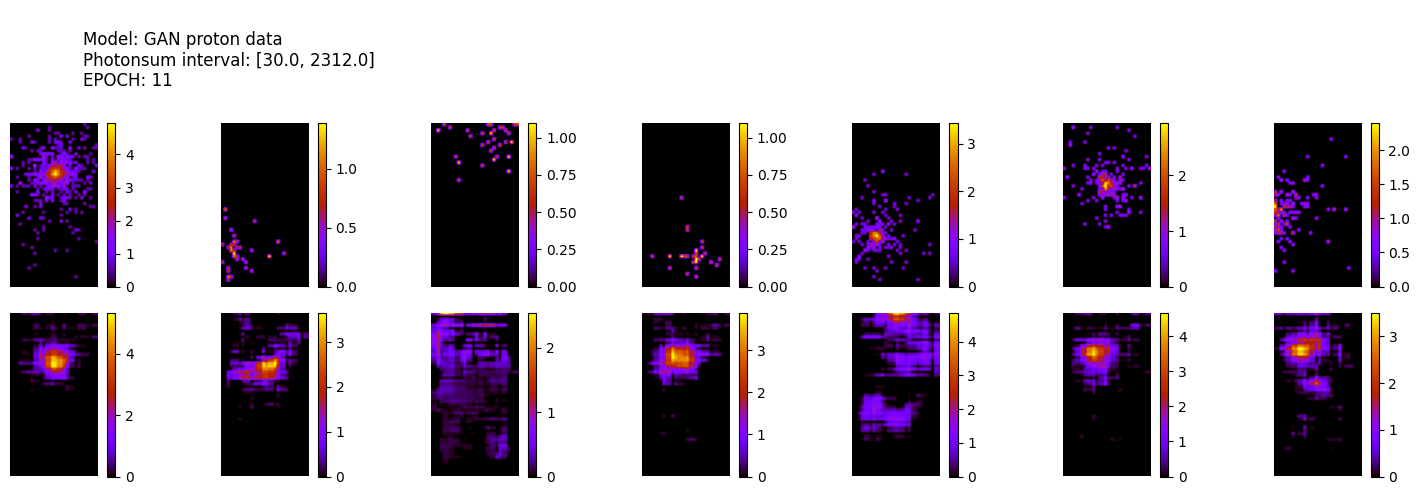

374/374 [==============================] - 1s 4ms/step
ws mean 165.02 ch1 0.53 ch2 232.87 ch3 0.51 ch4 178.83 ch5 412.34 Time for epoch 12 is 40.30225658416748 sec
4500 [D real acc: 79.60%] [D fake acc: 74.77%] [G acc: 25.23%] 
4600 [D real acc: 79.90%] [D fake acc: 75.03%] [G acc: 24.97%] 
4700 [D real acc: 80.19%] [D fake acc: 75.35%] [G acc: 24.65%] 
4800 [D real acc: 80.49%] [D fake acc: 75.69%] [G acc: 24.31%] 


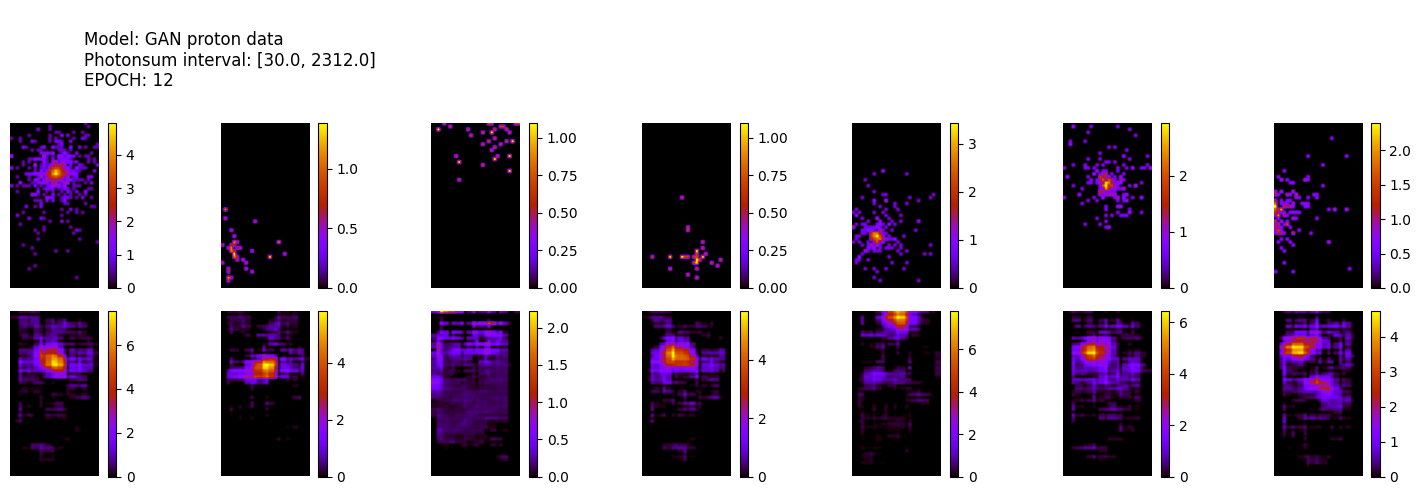

374/374 [==============================] - 1s 4ms/step
ws mean 947.52 ch1 1.65 ch2 579.74 ch3 8.38 ch4 1792.71 ch5 2355.11 Time for epoch 13 is 40.49211359024048 sec
4900 [D real acc: 80.79%] [D fake acc: 76.06%] [G acc: 23.94%] 
5000 [D real acc: 81.11%] [D fake acc: 76.43%] [G acc: 23.57%] 
5100 [D real acc: 81.43%] [D fake acc: 76.80%] [G acc: 23.20%] 
5200 [D real acc: 81.74%] [D fake acc: 77.16%] [G acc: 22.84%] 


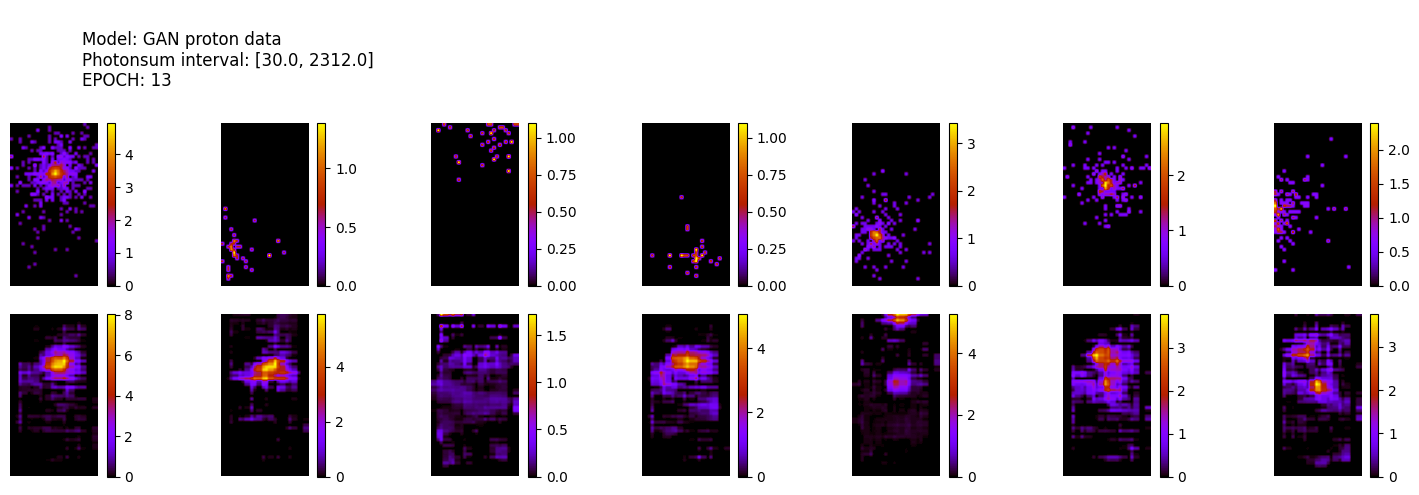

374/374 [==============================] - 1s 4ms/step
ws mean 6508.03 ch1 24.71 ch2 17434.29 ch3 1.02 ch4 335.97 ch5 14744.16 Time for epoch 14 is 40.16852831840515 sec
5300 [D real acc: 82.03%] [D fake acc: 77.51%] [G acc: 22.49%] 
5400 [D real acc: 82.33%] [D fake acc: 77.87%] [G acc: 22.13%] 
5500 [D real acc: 82.61%] [D fake acc: 78.22%] [G acc: 21.78%] 
5600 [D real acc: 82.86%] [D fake acc: 78.56%] [G acc: 21.44%] 


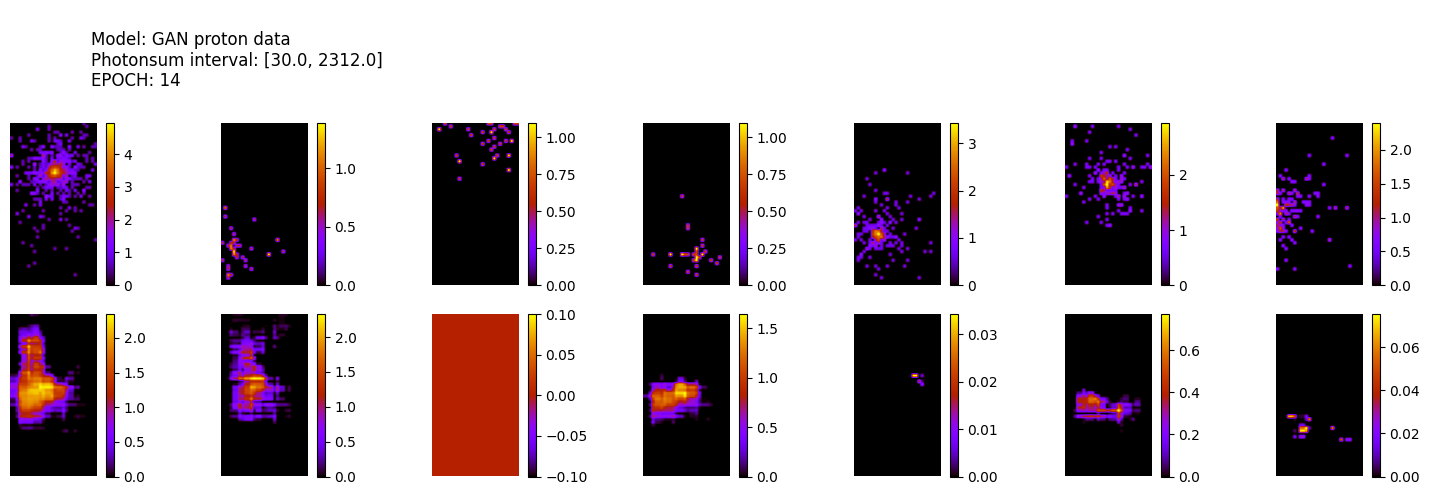

374/374 [==============================] - 1s 4ms/step
ws mean 71.50 ch1 0.19 ch2 50.31 ch3 0.31 ch4 129.33 ch5 177.36 Time for epoch 15 is 40.37335157394409 sec
5700 [D real acc: 83.14%] [D fake acc: 78.91%] [G acc: 21.09%] 
5800 [D real acc: 83.41%] [D fake acc: 79.26%] [G acc: 20.74%] 
5900 [D real acc: 83.67%] [D fake acc: 79.60%] [G acc: 20.40%] 


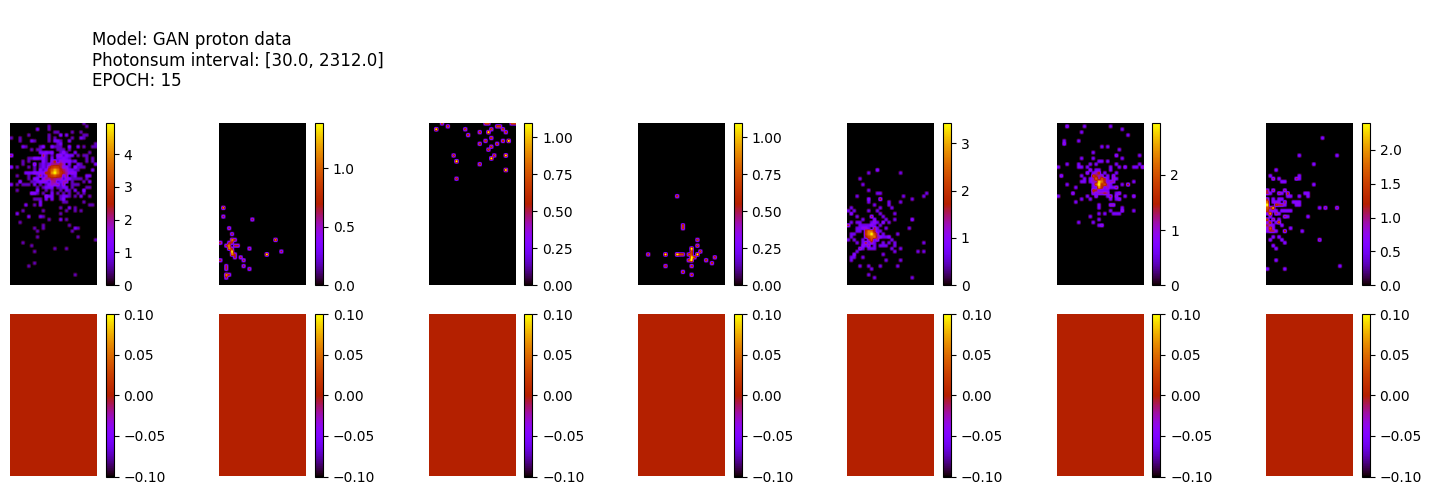

374/374 [==============================] - 1s 4ms/step
ws mean 89.62 ch1 0.22 ch2 80.69 ch3 0.35 ch4 143.25 ch5 223.58 Time for epoch 16 is 43.35249185562134 sec
6000 [D real acc: 83.92%] [D fake acc: 79.93%] [G acc: 20.07%] 
6100 [D real acc: 84.17%] [D fake acc: 80.25%] [G acc: 19.75%] 
6200 [D real acc: 84.41%] [D fake acc: 80.56%] [G acc: 19.44%] 
6300 [D real acc: 84.65%] [D fake acc: 80.87%] [G acc: 19.13%] 


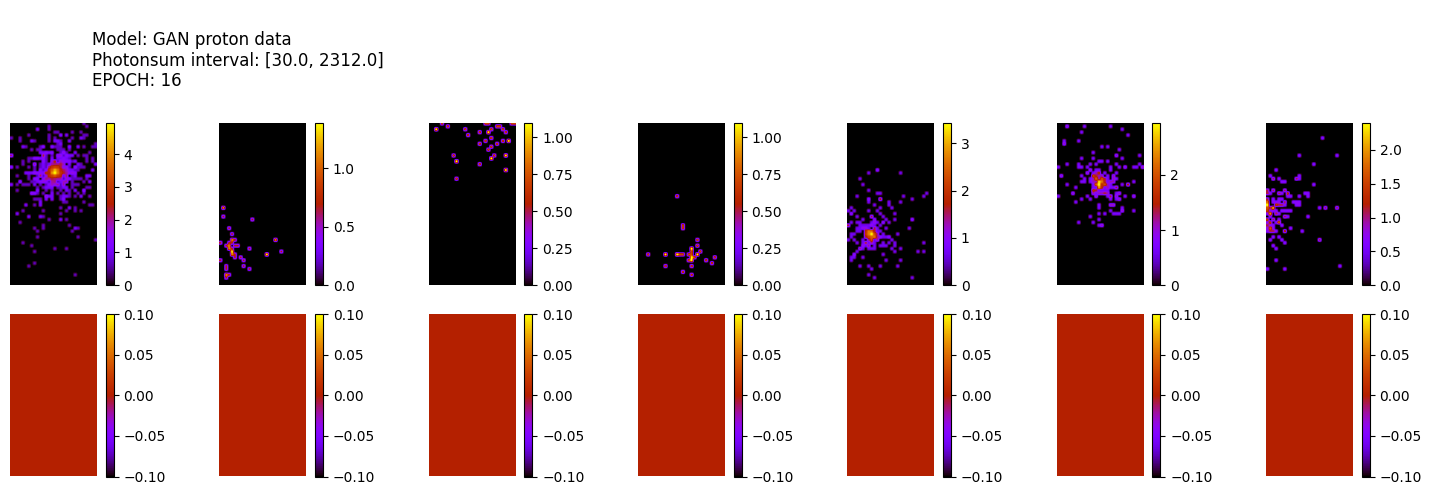

374/374 [==============================] - 1s 4ms/step
ws mean 86.77 ch1 0.18 ch2 74.51 ch3 0.35 ch4 142.33 ch5 216.51 Time for epoch 17 is 43.088401317596436 sec
6400 [D real acc: 84.89%] [D fake acc: 81.16%] [G acc: 18.84%] 
6500 [D real acc: 85.11%] [D fake acc: 81.43%] [G acc: 18.57%] 
6600 [D real acc: 85.32%] [D fake acc: 81.65%] [G acc: 18.35%] 
6700 [D real acc: 85.53%] [D fake acc: 81.87%] [G acc: 18.13%] 


In [ ]:
print("Images are saved in: ", filepath_img)
print("Models are saved in: ", filepath_mod)
history=train(dataset_with_cond, EPOCHS)